## Multimodal Retrieval Augmented Generation (RAG) with ImageBind

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

This example explores preparing, embedding, and storing both text and image data within a KDB.AI vector database. Our goal is to store both images and text within the same vector space so we can search over both modalities at the same time. KDB.AI can then be used as a retrieval tool within a RAG pipeline for both text and images, making it a multimodal retriever. 

The dataset we are working with contains images of several different animals, and text descriptions of those animals. After implementation, a user should be able to write a query regarding any of these animals and get returned both images and text related to the animal of interest.

The method in this notebook uses a multimodal embedding model from Meta called "ImageBind" to embed both text and images within the same vector space.

### Agenda:
0. Setup
1. Helper Functions
2. Prepare Data
3. Embed Texts and Images
4. Set Up KDB.AI Vector Database table
5. Insert data into KDB.AI Vector Database
6. Query Vector Database to Retrieve Most Relevant Data
7. Retrieval Augmented Generation
8. Drop the table

###### ImageBind Citation:
@inproceedings{girdhar2023imagebind,
  title={ImageBind: One Embedding Space To Bind Them All},
  author={Girdhar, Rohit and El-Nouby, Alaaeldin and Liu, Zhuang
and Singh, Mannat and Alwala, Kalyan Vasudev and Joulin, Armand and Misra, Ishan},
  booktitle={CVPR},
  year={2023}
}

ImageBind GitHub Repository: https://github.com/facebookresearch/ImageBind

Animal Images Source: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals


## 0. Setup
 Install ImageBind requirements and import necessary packages 

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install kdbai_client

In [2]:
import requests
import os
from PIL import Image
import io

In [ ]:
### !!! Only run this cell if running the notebook in Colab
### This downloads image and text data into Colab

!mkdir -p ./data/images
!mkdir -p ./data/text

def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"
    
    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./data/{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{folder_path}/{item['name']}"
            print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            file_path = f"{fPath}/{item['name']}"

            if item['name'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Save image file
                with Image.open(io.BytesIO(r.content)) as im:
                    im.save(file_path)
            else:
                # Save text file
                with open(file_path, 'wb') as f:
                    f.write(r.content)

# Get the data
get_github_repo_contents(
    repo_owner='KxSystems',
    repo_name='kdbai-samples',
    branch='main',
    folder_path='multimodal_RAG_ImageBind/data'
)

In [3]:
!git clone https://github.com/facebookresearch/ImageBind

Cloning into 'ImageBind'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 117 (delta 48), reused 35 (delta 35), pack-reused 47
Receiving objects: 100% (117/117), 2.64 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [4]:
### Move to the ImageBind directory
os.chdir('./ImageBind')

In [ ]:
### Install ImageBind dependencies !!! In Colab you may need to run this twice - do NOT restart runtime if prompted to.
!pip install .

In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import PIL
from PIL import Image
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

Instantiate the ImageBind model:

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

## 1. Helper Functions
read_text_from_file: Takes in text file and returns the text within that file

getEmbeddingVector: Runs data inputs through ImageBind and extracts the vector embedding

dataToEmbedding: Takes in the image or text file path and the data type and returns an embedded vector

queryToEmbedding:Takes a users query and returns an embedded query vector


In [8]:
# Helper function to read the text from a file
def read_text_from_file(filename):
    try:
        # Open the file in read mode ('r')
        with open(filename, 'r') as file:
            # Read the contents of the file into a string
            text = file.read()
            file.close()
        return text
    except IOError as e:
        # Handle any I/O errors
        print(f"An error occurred: {e}")
        return None
    

#Helper functions to create embeddings
def getEmbeddingVector(inputs):
    with torch.no_grad():
        embedding = model(inputs)
    for key, value in embedding.items():
        vec = value.reshape(-1)
        vec = vec.numpy()
        return(vec)

def dataToEmbedding(dataIn,dtype):
    if dtype == 'image':
        data_path = [dataIn]
        inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(data_path, device)
        }
    elif dtype == 'text':
        txt = [dataIn]
        inputs = {
        ModalityType.TEXT: data.load_and_transform_text(txt, device)
        }
    vec = getEmbeddingVector(inputs)
    return(vec)

# Helper function to create a query vector from a natural language query    
def queryToEmbedding(text):
    text = [text]
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text, device)
    }
    vec = getEmbeddingVector(inputs)
    return(vec)



## 2. Prepare Data
Define an empty dataframe to store embeddings and get a list of paths for images and text files

In [9]:
#Define a dataframe to put our embeddings and metadata into - this will later be used to load our vector database
columns = ['path','media_type','embeddings']
df = pd.DataFrame(columns=columns)

In [10]:
#Get a list of paths for images, text

images = os.listdir("../data/images")
texts = os.listdir("../data/text")

## 3. Embed Texts and Images
Loop through all images and texts, send them to helper functions to be embedded by ImageBind model

In [11]:
#loop through images, append a row in the dataframe containing each image's path, media_type (image), and embeddings
for image in images:
    path = "../data/images/" + image
    media_type = "image"
    embedding = dataToEmbedding(path,media_type)
    new_row = {'path': path,
               'media_type':media_type,
               'embeddings':embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [12]:
#Look at the shape of out df after loading in image embeddings
df.shape

(12, 3)

In [13]:
#Explore the df
df.head()

,path,media_type,embeddings
0,../data/images/caterpillar1.jpg,image,"[0.032080166, 0.0144777745, 0.03579446, -0.019..."
1,../data/images/fox1.jpg,image,"[0.007482125, -0.016735282, 0.03143912, -0.004..."
2,../data/images/caterpillar2.jpg,image,"[-0.0024396034, 0.017810794, 0.0247387, -0.027..."
3,../data/images/bear1.jpg,image,"[0.014970263, -0.011263392, -0.026858496, -0.0..."
4,../data/images/bat2.jpg,image,"[-0.010253589, 0.013193977, -0.0042155623, 0.0..."


In [14]:
#loop through texts, append a row in the dataframe containing each text's path, media_type (text), and embeddings
for text in texts:
    path = "../data/text/" + text
    media_type = "text"
    txt_file = read_text_from_file(path)
    #print(txt_file)
    embedding = dataToEmbedding(txt_file,media_type)
    new_row = {'path': path,
               'media_type':media_type,
               'embeddings':embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [15]:
#Look at the shape of out df after loading in text embeddings
df.shape

(18, 3)

In [16]:
#Explore the entire dataframe
df

,path,media_type,embeddings
0,../data/images/caterpillar1.jpg,image,"[0.032080166, 0.0144777745, 0.03579446, -0.019..."
1,../data/images/fox1.jpg,image,"[0.007482125, -0.016735282, 0.03143912, -0.004..."
2,../data/images/caterpillar2.jpg,image,"[-0.0024396034, 0.017810794, 0.0247387, -0.027..."
3,../data/images/bear1.jpg,image,"[0.014970263, -0.011263392, -0.026858496, -0.0..."
4,../data/images/bat2.jpg,image,"[-0.010253589, 0.013193977, -0.0042155623, 0.0..."
5,../data/images/deer2.jpg,image,"[0.025239628, -0.0017763297, 0.0065846415, 0.0..."
6,../data/images/fox2.jpg,image,"[0.034984913, -0.016432315, 0.0079426775, 0.01..."
7,../data/images/hedgehog1.jpg,image,"[0.03086756, -0.003478838, -0.026092423, -0.02..."
8,../data/images/deer1.jpg,image,"[0.0080552865, 0.0055562393, 0.045033015, 0.00..."
9,../data/images/hedgehog2.jpg,image,"[0.0075090756, 0.013892017, -0.019423133, -0.0..."


## 4. Set Up KDB.AI Vector Database table
Time to get KDB.AI vector database set up. If you do not have an account, go to KDB.AI to sign-up free!

In [17]:
# vector DB imports
import os
from getpass import getpass
import kdbai_client as kdbai
import time

##### Option 1. KDB.AI Cloud

To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key.
To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI Cloud session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [44]:
#Set up KDB.AI endpoing and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

KDB.AI endpoint: your_kdbai_endpoint
KDB.AI API key: ········


In [24]:
#connect to KDB.AI
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

##### Option 2. KDB.AI Server

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/). 

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.

In [18]:
session = kdbai.Session()

In [19]:
#Set up a table with three columns, path, media_type, and embeddings
#In embeddings, we use 1024 dimensions because that is the dimensionality that ImageBind outputs
#Using Cosine Similarity as our similarity search method, and a flat index
table_schema = {
    "columns": [
        {"name": "path", "pytype": "str"},
        {"name": "media_type", "pytype": "str"},
        {
            "name": "embeddings",
            "pytype": "float32",
            "vectorIndex": {"dims": 1024, "metric": "CS", "type": "flat"},
        },
    ]
}

In [20]:
# First ensure the table does not already exist
try:
    session.table("multi_modal_ImageBind").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [21]:
#Create the table called "multi_modal_demo"
table = session.create_table("multi_modal_ImageBind", table_schema)

## 5. Insert data into KDB.AI Vector Database

In [23]:
#Insert the data into the table, split into 2000 row batches
from tqdm import tqdm 
n = 2000  # chunk row size

for i in tqdm(range(0, df.shape[0], n)):
    table.insert(df[i:i+n].reset_index(drop=True))

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


In [24]:
#Explore what is in the table/vector database
table.query()

,path,media_type,embeddings
0,../data/images/caterpillar1.jpg,image,"[0.032080166, 0.0144777745, 0.03579446, -0.019..."
1,../data/images/fox1.jpg,image,"[0.007482125, -0.016735282, 0.03143912, -0.004..."
2,../data/images/caterpillar2.jpg,image,"[-0.0024396034, 0.017810794, 0.0247387, -0.027..."
3,../data/images/bear1.jpg,image,"[0.014970263, -0.011263392, -0.026858496, -0.0..."
4,../data/images/bat2.jpg,image,"[-0.010253589, 0.013193977, -0.0042155623, 0.0..."
5,../data/images/deer2.jpg,image,"[0.025239628, -0.0017763297, 0.0065846415, 0.0..."
6,../data/images/fox2.jpg,image,"[0.034984913, -0.016432315, 0.0079426775, 0.01..."
7,../data/images/hedgehog1.jpg,image,"[0.03086756, -0.003478838, -0.026092423, -0.02..."
8,../data/images/deer1.jpg,image,"[0.0080552865, 0.0055562393, 0.045033015, 0.00..."
9,../data/images/hedgehog2.jpg,image,"[0.0075090756, 0.013892017, -0.019423133, -0.0..."


## 6. Query Vector Database to Retrieve Most Relevant Data 
Our vector database now contains embeddings representing both text files and images! We can query the vector database to find the most relevant animal based on our query. 

Retrieved results can then be sent to an LLM for RAG

In [25]:
# Helper function to view the results of our similarity search
def viewResults(results):
    for index, row in results[0].iterrows():
        if row[1] == 'image':
            image = Image.open(row[0])
            display(image)
        elif row[1] == 'text':
            text = read_text_from_file(row[0])
            print(text)

# Multimodal search function, identifies most relevant images and text within the vector database
def mm_search(query):
    image_results = table.search(query_vector, n=2, filter=[("=", "media_type", "image")])
    text_results = table.search(query_vector, n=1, filter=[("=", "media_type", "text")])
    results = [pd.concat([image_results[0], text_results[0]], ignore_index=True)]
    viewResults(results)
    return(results)

In [26]:
#Create a query vector to do similarity search against
query_vector = [queryToEmbedding("large brown furry animal").tolist()]

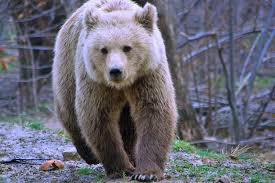

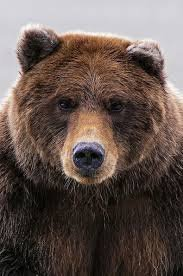

Bears are large mammals with a stocky body, powerful limbs, and a short tail. They have a large brain and are considered among the most intelligent of animals. While many bears are omnivorous, their diets can range from primarily plant-based to entirely carnivorous, depending on the species.


In [27]:
#Execute a similarity search
results = mm_search(query_vector)

In [28]:
#Try another query
query_vector = [queryToEmbedding("brown animal with antlers").tolist()]

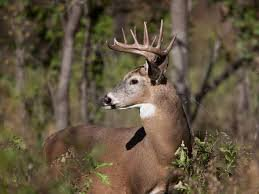

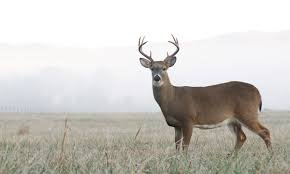

Deer are hoofed mammals known for their graceful bodies and long legs. Most male deer have antlers, which they shed and regrow annually. They are herbivores, generally feeding on a mix of grasses, plants, and leaves. Deer are found in various habitats, including forests, grasslands, and wetlands.


In [29]:
#Execute a similarity search
results = mm_search(query_vector)

In [30]:
#Try another query
query_vector = [queryToEmbedding("green and yellow insect that cacoons").tolist()]

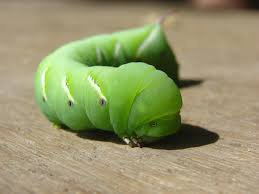

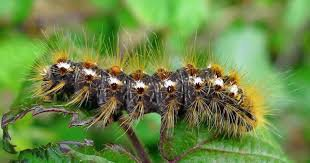

Caterpillars are the larval stage of butterflies and moths. They have a segmented body with a distinct head and typically several pairs of true legs, as well as additional false legs or prolegs. Caterpillars are primarily known for their voracious appetite, often eating leaves before pupating into their adult form.


In [31]:
#Execute a similarity search
results = mm_search(query_vector)

Now we have retrieved the most relevant text and images from KDB.AI vector database, the retrieval step of RAG is complete!

## 7. RAG Time!
We will use Google's Gemini Vision model to handle input text and images. We can now take our retrieved data and pass it to Gemini for the second phase of RAG: Generation

In [32]:
# Pip install necessary packages (!!! Note: On Colab, some Google packages may already be installed: do NOT restart the runtime if prompted to)
!pip install google-generativeai langchain-google-genai streamlit pillow

Defaulting to user installation because normal site-packages is not writeable


In [40]:
# Setup Google API Key, get it here: https://makersuite.google.com/
import os
from getpass import getpass
os.environ["GOOGLE_API_KEY"] = (
    os.environ["GOOGLE_API_KEY"]
    if "GOOGLE_API_KEY" in os.environ
    else getpass("Google API Key: ")
)

In [34]:
import google.generativeai as genai
genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

In [35]:
# Use Gemini Pro Vision model to handle multimodal inputs
vision_model = genai.GenerativeModel('gemini-pro-vision')

In [36]:
# Helper function to get retrieved data ready to send to Gemini
def RAG_Setup(results,retrieved_data_for_RAG):
    for index, row in results[0].iterrows():
        if row[1] == 'image':
            image = Image.open(row[0])
            retrieved_data_for_RAG.append(image)
        elif row[1] == 'text':
            text = read_text_from_file(row[0])
            retrieved_data_for_RAG.append(text)
    return retrieved_data_for_RAG


Construct the query to send to Gemini:

In [37]:
prompt = "what can you tell me about caterpillars in the images? What species are they?"

#This will serve as the prompt being sent to Gemini:
query = "You will answer the given prompt using attached content: " + prompt

#Gemini accepts a list of inputs, which include texts and images retrieved from the vector database
#This input list will begin with the query defined above
RAG_list = [query]

#The input list and retrieved results are now passed into the RAG_Setup helper function
#retieved_data_for_RAG will now contain a list including the prompt and retrieved text/image data
retrieved_data_for_RAG = RAG_Setup(results, RAG_list)



Execute generation step of RAG:

In [38]:
#Gemini generates a response based on the retrieved_data_for_RAG input list, completing the RAG iteration
response = vision_model.generate_content(retrieved_data_for_RAG)
print(response.text)

 The caterpillar in the first image is a green larva with black spots and a white stripe down its back. It is likely a tobacco hornworm, which is a common pest of tobacco plants. The caterpillar in the second image is a brown and hairy larva with white spots along its back. It is likely a tussock moth caterpillar, which is a common pest of trees.


## 8. Delete the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()